## Mount GoogleDrive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parameters

In [2]:
# Dataset
dataset_folder_path = '/content/gdrive/MyDrive/deephomography/dataset/'
rho = 32
patch_size = 128
image_size = (320,240)

# Dataloader
batch_size = 64
dataset_mean = 113.55

# Training
num_iterations = 90000
checkpoint_path = '/content/gdrive/MyDrive/deephomography/models/checkpoint.pth'

# Create required folder(s)
!mkdir -p $(dirname {checkpoint_path})

## Extract dataset

In [3]:
!echo "Extracting train2014homography.tar..."
!tar -xf {dataset_folder_path}/train2014homography.tar

!echo "Extracting val2014homography.tar..."
!tar -xf {dataset_folder_path}/val2014homography.tar

!echo "Extracting test2014homography.tar..."
!tar -xf {dataset_folder_path}/test2014homography.tar

Extracting train2014homography.tar...
Extracting val2014homography.tar...
Extracting test2014homography.tar...


## Homography Estimation with Deep Neural Networks 

### Custom PyTorch dataset & dataloader

In [4]:
import os
import numpy as np
import torch

class HomographyDataset(torch.utils.data.Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path

        # List folder contents
        self.file_list = os.listdir(self.folder_path)

        # Set dataset size
        self.size = len(self.file_list)
    
    def __len__(self):
        return self.size

    def __getitem__(self, index):
        # Load sample
        patch, perturbed_patch, patch_points, perturbation = np.load(os.path.join(self.folder_path, self.file_list[index]), allow_pickle=True)

        # Normalisation
        patch = patch.astype(np.float32) - dataset_mean
        perturbed_patch = perturbed_patch.astype(np.float32) - dataset_mean
        perturbation = perturbation.astype(np.float32) / rho

        # Convert to PyTorch object
        patch = torch.unsqueeze(torch.from_numpy(patch), dim=0)
        perturbed_patch = torch.unsqueeze(torch.from_numpy(perturbed_patch), dim=0)
        perturbation = torch.flatten(torch.from_numpy(perturbation))

        # Stack two patches into a single tensor
        patch_pair = torch.concat((patch, perturbed_patch), dim=0)

        return patch_pair, perturbation

# Datasets
train_dataset = HomographyDataset(folder_path='train2014homography')
validation_dataset = HomographyDataset(folder_path='val2014homography')
test_dataset = HomographyDataset(folder_path='test2014homography')

# Number of processors
num_proc = len(os.sched_getaffinity(0))

# Dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_proc)
validation_dataloader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True, num_workers=num_proc)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_proc)

### Network definition

In [5]:
class HomographyNet(torch.nn.Module):
    def __init__(self):
        super().__init__() # don't remove this line
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU())
                                    
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU())
        
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU()) 
              
        self.conv6 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        self.conv7 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU())
        
        self.conv8 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))
        
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=128*16*16, out_features=1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))
        
        self.fc2 = torch.nn.Sequential(
            torch.nn.Linear(in_features=1024, out_features=8))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

homographynet = HomographyNet().to('cuda')

### Test network shapes

In [6]:
import torchsummary

for dummy_input, dummy_label in train_dataloader:
    dummy_input, dummy_label = dummy_input.to('cuda'), dummy_label.to('cuda')

    dummy_output = homographynet(dummy_input)

    torchsummary.summary(homographynet, dummy_input.shape[1:])
    #print(homographynet)

    print(f'Dummy input shape: {dummy_input.shape}')
    print(f'Dummy label shape: {dummy_label.shape}')
    print(f'Dummy output shape: {dummy_output.shape}')
    print()

    if dummy_label.shape != dummy_output.shape:
        raise Exception("Shape mismatch for label and output!") 
    else:
        print("Label and output shapes are consistent.")

    break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,216
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,928
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

### Optimizer and loss function

In [7]:
# Optimizer
homographynet_optim = torch.optim.SGD(homographynet.parameters(), lr=0.005, momentum=0.9)

# Loss function
homographynet_lossfn = torch.nn.MSELoss()

### Validation/Test function

In [8]:
def average_corner_error(true, pred):
    true_scaled = rho * true.cpu().numpy()
    pred_scaled = rho * pred.cpu().numpy()

    squared_error = np.square(true_scaled - pred_scaled)

    batch_ace = (np.sqrt(squared_error[:,0] + squared_error[:,1]) + 
                 np.sqrt(squared_error[:,2] + squared_error[:,3]) + 
                 np.sqrt(squared_error[:,4] + squared_error[:,5]) + 
                 np.sqrt(squared_error[:,6] + squared_error[:,7])) / 4

    return np.mean(batch_ace, axis=0)

def test_model(model, dataloader, lossfn):
    # Set network to eval mode
    model.eval()

    # Initialise total loss and average corner error
    total_loss = 0
    total_ace = 0
    
    # Disable gradients inside this block
    with torch.no_grad():
        for patch_pair, H_fp in dataloader:
            # Move batch to GPU
            patch_pair, H_fp = patch_pair.cuda(), H_fp.cuda()

            # Run the network and obtain predicted homography 
            H_fp_pred = model(patch_pair)

            # Calculate loss
            total_loss += lossfn(H_fp, H_fp_pred)

            # Calculate average corner error
            total_ace += average_corner_error(H_fp, H_fp_pred)

    # Calculate mean loss
    mean_loss = total_loss / len(dataloader)

    # Calculate mean average corner error
    mean_ace = total_ace / len(dataloader)

    # Set network to train mode
    model.train()
    
    return mean_loss, mean_ace

### Training

In [9]:
ep_start = 0
training_loss_list = []
validation_loss_list = []

# Calculate number of epochs
num_epochs = np.ceil(num_iterations / len(train_dataloader)).astype(int)

# Calculate number of reporting steps
num_report_steps = np.floor(len(train_dataloader) / 10)

# Calculate required digits for number of total epochs and iterations (for reporting)
epd = len(str(num_epochs))
itd = len(str(len(train_dataloader)))

# Check if a checkpoint exists
if os.path.isfile(checkpoint_path):
    # Load checkpoint
    print('Loading checkpoint...')
    checkpoint = torch.load(checkpoint_path)

    # Load variables from checkpoint
    ep_start = checkpoint['epoch']
    homographynet.load_state_dict(checkpoint['network_state'])
    homographynet_optim.load_state_dict(checkpoint['optim_state'])
    training_loss_list = checkpoint['tloss_list']
    validation_loss_list = checkpoint['vloss_list']

for ep in range(ep_start, num_epochs):
    # Initialise total loss
    total_loss = 0

    for it, (patch_pair, H_fp) in enumerate(train_dataloader):
        # Move batch to GPU
        patch_pair, H_fp = patch_pair.to("cuda"), H_fp.to("cuda")
        
        # Run the network and obtain predicted homography 
        H_fp_pred = homographynet(patch_pair)

        # Calculate loss
        loss = homographynet_lossfn(H_fp, H_fp_pred)
        total_loss += loss
        
        # Take an optimization step (clear the gradients first)
        homographynet_optim.zero_grad()
        loss.backward()
        homographynet_optim.step()
        
        if (it == 0 or (it + 1) % num_report_steps == 0):
            print(f'[Epoch: {(ep + 1):0{epd}d}/{num_epochs}, Iteration: {(it + 1):0{itd}d}/{len(train_dataloader)}] Iteration Loss (MSE): {loss:.6f}')
    
    # Calculate average training loss
    training_loss = total_loss / len(train_dataloader)
    training_loss_list.append(training_loss)

    # Try model on validation set and calculate 
    validation_loss, validation_ace = test_model(homographynet, validation_dataloader, homographynet_lossfn)
    validation_loss_list.append(validation_loss)

    print(f'[Epoch: {(ep + 1):0{epd}d}/{num_epochs}, Iteration: {(it + 1):0{itd}d}/{len(train_dataloader)}] Training Loss (MSE): {training_loss:.6f}, Validation Loss (MSE): {validation_loss:.6f}, Validation Corner Error (MACE): {validation_ace:.4f}')

    # Save checkpoint
    print('Saving checkpoint...')
    torch.save({'epoch': ep+1, 'network_state': homographynet.state_dict(), 'optim_state': homographynet_optim.state_dict(), 'tloss_list': training_loss_list, 'vloss_list': validation_loss_list}, checkpoint_path)

[Epoch: 01/12, Iteration: 0001/7813] Iteration Loss (MSE): 0.464558
[Epoch: 01/12, Iteration: 0781/7813] Iteration Loss (MSE): 0.208769
[Epoch: 01/12, Iteration: 1562/7813] Iteration Loss (MSE): 0.152548
[Epoch: 01/12, Iteration: 2343/7813] Iteration Loss (MSE): 0.131850
[Epoch: 01/12, Iteration: 3124/7813] Iteration Loss (MSE): 0.121496
[Epoch: 01/12, Iteration: 3905/7813] Iteration Loss (MSE): 0.101339
[Epoch: 01/12, Iteration: 4686/7813] Iteration Loss (MSE): 0.077272
[Epoch: 01/12, Iteration: 5467/7813] Iteration Loss (MSE): 0.080910
[Epoch: 01/12, Iteration: 6248/7813] Iteration Loss (MSE): 0.086340
[Epoch: 01/12, Iteration: 7029/7813] Iteration Loss (MSE): 0.087685
[Epoch: 01/12, Iteration: 7810/7813] Iteration Loss (MSE): 0.080720
[Epoch: 01/12, Iteration: 7813/7813] Training Loss (MSE): 0.130759, Validation Loss (MSE): 0.062111, Validation Corner Error (MACE): 9.4670
Saving checkpoint...
[Epoch: 02/12, Iteration: 0001/7813] Iteration Loss (MSE): 0.083670
[Epoch: 02/12, Iteratio

### Testing

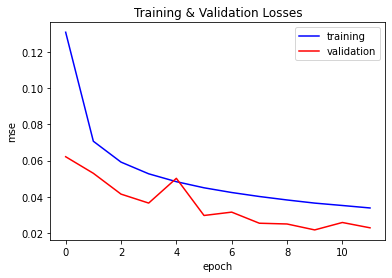


Minimum training loss (MSE): 0.03385247
Minimum validation loss (MSE): 0.02174733

Testing model...
Test loss (MSE): 0.02326978
Test corner error (MACE): 5.5338


In [10]:
import matplotlib.pyplot as plt

# Load checkpoint from file
checkpoint = torch.load(checkpoint_path)

# Load variables from checkpoint
ep_start = checkpoint['epoch']
homographynet.load_state_dict(checkpoint['network_state'])
training_loss_list_cuda = checkpoint['tloss_list']
validation_loss_list_cuda = checkpoint['vloss_list']

# Move losses to CPU and convert to Numpy
training_loss_list = [i.cpu().detach().numpy() for i in training_loss_list_cuda]
validation_loss_list = [i.cpu().detach().numpy() for i in validation_loss_list_cuda]

# Plot learning curve
plt.figure()
plt.title('Training & Validation Losses')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.plot(training_loss_list, 'b', validation_loss_list, 'r')
plt.legend(['training','validation'])
plt.show()

# Print minimum training and validation losses
print()
print(f'Minimum training loss (MSE): {min(training_loss_list):.8f}')
print(f'Minimum validation loss (MSE): {min(validation_loss_list):.8f}')
print()

print('Testing model...')
test_loss, test_ace = test_model(homographynet, test_dataloader, homographynet_lossfn)

print(f'Test loss (MSE): {test_loss:.8f}')
print(f'Test corner error (MACE): {test_ace:.4f}')

In [11]:
drive.flush_and_unmount()